## Lynda.com
numpy essential training: beautiful plots and the gallery

https://matplotlib.org/gallery.html

Note: R's ggplot2 is much easier than matplotlib :p

In [11]:
%matplotlib inline

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

### Named Colors
This example is taken from: http:matplotlib.org/examples/color/named_colors.html

### Hue, Saturation, Value
Explanation available at: https://en.wikipedia.org/wiki/HSL_and_HSV

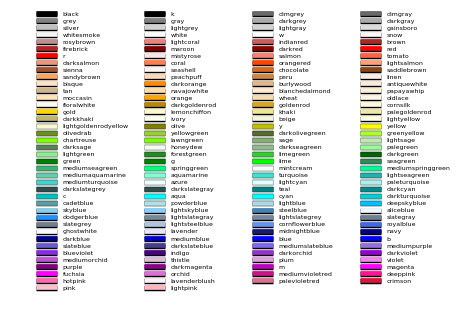

In [13]:
"""
Visualization of named colors

simple plot example with the named colors and its visual representation
"""

import six

colors_ = list(six.iteritems(colors.cnames))

# add the single letter colors.
for name, rgb in six.iteritems((colors.ColorConverter.colors)):
    hex_ = colors.rgb2hex(rgb)
    colors_.append((name, hex_))
    
# transform to hex color values.
hex_ = [color[1] for color in colors_]
# get the rgb equivalent
rgb = [colors.hex2color(color) for color in hex_]
# get the hsv equivalent.
hsv = [colors.rgb_to_hsv(color) for color in rgb]

# split the hsv values to sort
hue = [color[0] for color in hsv]
sat = [color[1] for color in hsv]
val = [color[2] for color in hsv]

# sort by hue, saturation and value
ind = np.lexsort((val, sat, hue))
sorted_colors = [colors_[i] for i in ind]

n = len(sorted_colors)
ncols = 4
nrows = int(np.ceil(1. * n / ncols))

fig, ax = plt.subplots()

X, Y = fig.get_dpi() * fig.get_size_inches()

# row height
h = Y / (nrows + 1)
# col width
w = X / ncols

for i, (name, color) in enumerate(sorted_colors):
    col = i % ncols
    row = int(i / ncols)
    y = Y - (row * h) - h
    
    xi_line = w * (col + 0.05)
    xf_line = w * (col + 0.25)
    xi_text = w * (col + 0.3)
    
    ax.text(xi_text, y, name, fontsize=(h * 0.8),
            horizontalalignment='left',
            verticalalignment='center')
    
    # add extra black line a little bit thicker to make
    # clear colors more visible
    ax.hlines(y, xi_line, xf_line, color='black', linewidth=(h * 0.7))
    ax.hlines(y + h * 0.1, xi_line, xf_line, color=color, linewidth=(h * 0.6))

ax.set_xlim(0, X)
ax.set_ylim(0, Y)
ax.set_axis_off()

fig.subplots_adjust(left=0, right=1,
                   top=1, bottom=0,
                   hspace=0, wspace=0)

plt.show()

### Violin plot vs Box plot
This example is taken from: http://matplotlib.org/examples/statistics/boxplot_vs_violin_demo.html

for more information on violin plots: https://en.wikipedia.org/wiki/Violin_plot

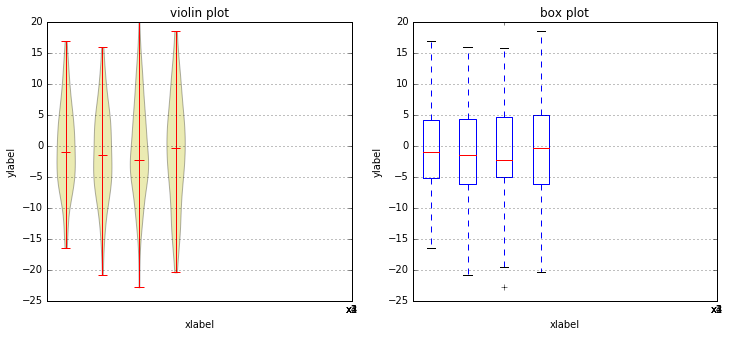

In [14]:
"""
Box plot - violin plot comparison

Note that although violin plots are closely related to Tukey's (1977) box plots,
they add useful information such as the distribution o the sample dta (density trace).

By default, box plots show data points outside 1.5 x the inter-quartile range as outliers
above and below the whiskers whereas violin plots show the whol range of data

violin plots requrie matplotlib >= 1.4.

"""

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# generate some random test data
all_data = [np.random.normal(0, std, 100) for std in range(6, 10)]

# plot violin plot
axes[0].violinplot(all_data,
                  showmeans=False,
                  showmedians=True)
axes[0].set_title('violin plot')

# plot box lot
axes[1].boxplot(all_data)
axes[1].set_title('box plot')

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('xlabel')
    ax.set_ylabel('ylabel')
    
# add x-tick labels
plt.setp(axes, xticks=[y+1 for ry in range(len(all_data))],
        xticklabels=['x1', 'x2', 'x3', 'x4'])
plt.show()

### Financial Data
This example is taken from: http://matplotlib.org/examples/pylab_examples/finance_work2.html

for information about matplotlib style sheets and setting "rc" values, please see: http://matplotlib.org/users/customizing.html and http://matplotlib.org/api/matplotlib_configuration_api.html#matplotlib.rc

In [15]:
import datetime
import numpy as np
import matplotlib.colors as colors
import matplotlib.finance as finance
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager


startdate = datetime.date(2006, 1, 1)
today = enddate = datetime.date.today()
ticker = 'SPY'


fh = finance.fetch_historical_yahoo(ticker, startdate, enddate)
# a numpy record array with fields: date, open, high, low, close, volume, adj_close)

r = mlab.csv2rec(fh)
fh.close()
r.sort()


def moving_average(x, n, type='simple'):
    """
    compute an n period moving average.

    type is 'simple' | 'exponential'

    """
    x = np.asarray(x)
    if type == 'simple':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))

    weights /= weights.sum()

    a = np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    return a


def relative_strength(prices, n=14):
    """
    compute the n period relative strength indicator
    http://stockcharts.com/school/doku.php?id=chart_school:glossary_r#relativestrengthindex
    http://www.investopedia.com/terms/r/rsi.asp
    """

    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed >= 0].sum()/n
    down = -seed[seed < 0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n - 1) + upval)/n
        down = (down*(n - 1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)

    return rsi


def moving_average_convergence(x, nslow=26, nfast=12):
    """
    compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = moving_average(x, nslow, type='exponential')
    emafast = moving_average(x, nfast, type='exponential')
    return emaslow, emafast, emafast - emaslow


plt.rc('axes', grid=True)
plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)

textsize = 9
left, width = 0.1, 0.8
rect1 = [left, 0.7, width, 0.2]
rect2 = [left, 0.3, width, 0.4]
rect3 = [left, 0.1, width, 0.2]


fig = plt.figure(facecolor='white')
axescolor = '#f6f6f6'  # the axes background color

ax1 = fig.add_axes(rect1, axisbg=axescolor)  # left, bottom, width, height
ax2 = fig.add_axes(rect2, axisbg=axescolor, sharex=ax1)
ax2t = ax2.twinx()
ax3 = fig.add_axes(rect3, axisbg=axescolor, sharex=ax1)


# plot the relative strength indicator
prices = r.adj_close
rsi = relative_strength(prices)
fillcolor = 'darkgoldenrod'

ax1.plot(r.date, rsi, color=fillcolor)
ax1.axhline(70, color=fillcolor)
ax1.axhline(30, color=fillcolor)
ax1.fill_between(r.date, rsi, 70, where=(rsi >= 70), facecolor=fillcolor, edgecolor=fillcolor)
ax1.fill_between(r.date, rsi, 30, where=(rsi <= 30), facecolor=fillcolor, edgecolor=fillcolor)
ax1.text(0.6, 0.9, '>70 = overbought', va='top', transform=ax1.transAxes, fontsize=textsize)
ax1.text(0.6, 0.1, '<30 = oversold', transform=ax1.transAxes, fontsize=textsize)
ax1.set_ylim(0, 100)
ax1.set_yticks([30, 70])
ax1.text(0.025, 0.95, 'RSI (14)', va='top', transform=ax1.transAxes, fontsize=textsize)
ax1.set_title('%s daily' % ticker)

# plot the price and volume data
dx = r.adj_close - r.close
low = r.low + dx
high = r.high + dx

deltas = np.zeros_like(prices)
deltas[1:] = np.diff(prices)
up = deltas > 0
ax2.vlines(r.date[up], low[up], high[up], color='black', label='_nolegend_')
ax2.vlines(r.date[~up], low[~up], high[~up], color='black', label='_nolegend_')
ma20 = moving_average(prices, 20, type='simple')
ma200 = moving_average(prices, 200, type='simple')

linema20, = ax2.plot(r.date, ma20, color='blue', lw=2, label='MA (20)')
linema200, = ax2.plot(r.date, ma200, color='red', lw=2, label='MA (200)')


last = r[-1]
s = '%s O:%1.2f H:%1.2f L:%1.2f C:%1.2f, V:%1.1fM Chg:%+1.2f' % (
    today.strftime('%d-%b-%Y'),
    last.open, last.high,
    last.low, last.close,
    last.volume*1e-6,
    last.close - last.open)
t4 = ax2.text(0.3, 0.9, s, transform=ax2.transAxes, fontsize=textsize)

props = font_manager.FontProperties(size=10)
leg = ax2.legend(loc='center left', shadow=True, fancybox=True, prop=props)
leg.get_frame().set_alpha(0.5)


volume = (r.close*r.volume)/1e6  # dollar volume in millions
vmax = volume.max()
poly = ax2t.fill_between(r.date, volume, 0, label='Volume', facecolor=fillcolor, edgecolor=fillcolor)
ax2t.set_ylim(0, 5*vmax)
ax2t.set_yticks([])


# compute the MACD indicator
fillcolor = 'darkslategrey'
nslow = 26
nfast = 12
nema = 9
emaslow, emafast, macd = moving_average_convergence(prices, nslow=nslow, nfast=nfast)
ema9 = moving_average(macd, nema, type='exponential')
ax3.plot(r.date, macd, color='black', lw=2)
ax3.plot(r.date, ema9, color='blue', lw=1)
ax3.fill_between(r.date, macd - ema9, 0, alpha=0.5, facecolor=fillcolor, edgecolor=fillcolor)


ax3.text(0.025, 0.95, 'MACD (%d, %d, %d)' % (nfast, nslow, nema), va='top',
         transform=ax3.transAxes, fontsize=textsize)

#ax3.set_yticks([])
# turn off upper axis tick labels, rotate the lower ones, etc
for ax in ax1, ax2, ax2t, ax3:
    if ax != ax3:
        for label in ax.get_xticklabels():
            label.set_visible(False)
    else:
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_horizontalalignment('right')

    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')


class MyLocator(mticker.MaxNLocator):
    def __init__(self, *args, **kwargs):
        mticker.MaxNLocator.__init__(self, *args, **kwargs)

    def __call__(self, *args, **kwargs):
        return mticker.MaxNLocator.__call__(self, *args, **kwargs)

# at most 5 ticks, pruning the upper and lower so they don't overlap
# with other ticks
#ax2.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))
#ax3.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))

ax2.yaxis.set_major_locator(MyLocator(5, prune='both'))
ax3.yaxis.set_major_locator(MyLocator(5, prune='both'))

plt.show()

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

### Three dimensional surface plot
This example is from: http://matplotlib.org/examples/mplot3d/trisurf3d_demo.html

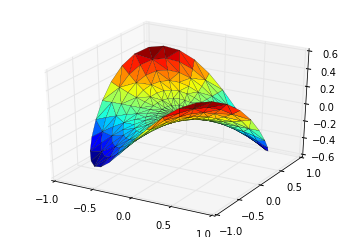

In [16]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

n_angles = 36
n_radii = 8

# An array of radii
# Does not include radius r=0, this is to eliminate duplicate points
radii = np.linspace(0.125, 1.0, n_radii)

# An array of angles
angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)

# Repeat all angles for each radius
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)

# Convert polar (radii, angles) coords to cartesian (x, y) coords
# (0, 0) is added here. There are no duplicate points in the (x, y) plane
x = np.append(0, (radii*np.cos(angles)).flatten())
y = np.append(0, (radii*np.sin(angles)).flatten())

# Pringle surface
z = np.sin(-x*y)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.2)

plt.show()